In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import requests
import pandas as pd
import plotly.express as px

In [ ]:
def download_file(file_url, file_path):
    response = requests.get(file_url)

    if response.status_code == 200:
      with open(file_path, 'wb') as file:
        file.write(response.content)
        print("File downloaded with success!")
    else:
        print("Failed to download the file.")

In [ ]:
genre_hierarchy_url = 'https://drive.google.com/uc?export=download&id=1SQlbm62aJbWfPcVa6SqEsKOdGaTNgDUB'
genre_hierarchy_path = '/content/sample_data/genre-hierarchy-modified.txt'
download_file(genre_hierarchy_url, genre_hierarchy_path)

File downloaded with success!


In [ ]:
def create_genre_graph(file_path):
    G = nx.DiGraph()

    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            genre_id, parent_id, level, genre_name = line.strip().split('\t')
            genre_id, parent_id, level = int(genre_id), int(parent_id), int(level)

            G.add_node(genre_id, label=genre_name, level=level)

            # Adiciona a aresta ao grafo, exceto para o nó raiz
            if genre_id != parent_id:
                G.add_edge(parent_id, genre_id)

    return G

In [ ]:
def draw_genre_graph(G):
    pos = nx.multipartite_layout(G, subset_key="level")
    labels = nx.get_node_attributes(G, 'label')
    levels = nx.get_node_attributes(G, 'level')
    node_colors = [levels[node] for node in G]

    plt.figure(figsize=(14, 14))
    nx.draw(G, pos, labels=labels, with_labels=True, node_size=0, cmap=plt.cm.plasma, font_size=10, font_weight='bold', edge_color='gray')
    plt.title("Hierarquia dos Gêneros Musicais")
    plt.axis('off')
    plt.show()

/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:457: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



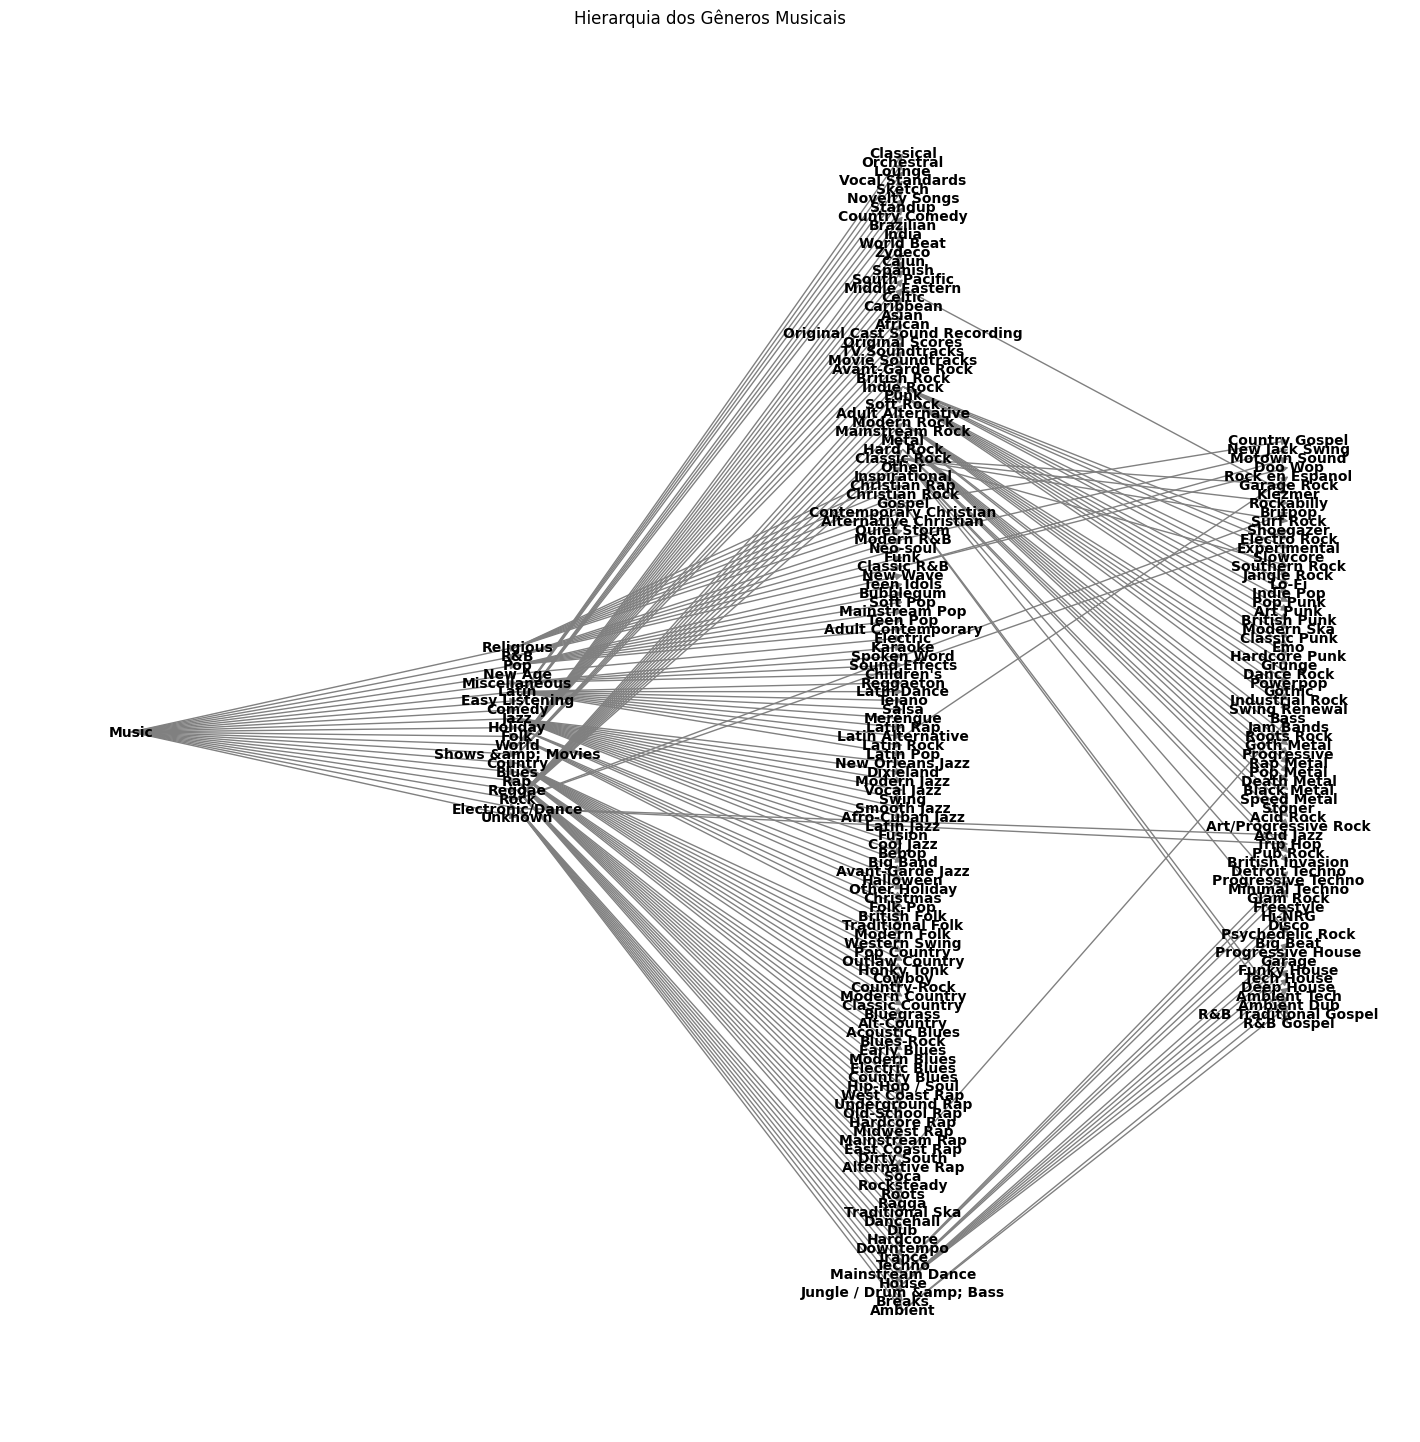

In [ ]:
G = create_genre_graph(genre_hierarchy_path)

draw_genre_graph(G)

In [ ]:
# Função para gerar um subgrafo a partir de um gênero raiz
def create_subgraph(G, root_genre_name):
    root_genre_id = None
    for node, data in G.nodes(data=True):
        if data['label'] == root_genre_name:
            root_genre_id = node
            break

    if root_genre_id is None:
        raise ValueError(f"Gênero raiz '{root_genre_name}' não encontrado.")

    descendants = nx.descendants(G, root_genre_id)
    descendants.add(root_genre_id)  # incluir o próprio gênero raiz

    subgraph = G.subgraph(descendants).copy()

    return subgraph

In [ ]:
def draw_subgraph(subgraph):
    pos = nx.multipartite_layout(subgraph, subset_key="level")
    labels = nx.get_node_attributes(subgraph, 'label')
    levels = nx.get_node_attributes(subgraph, 'level')
    node_colors = [levels[node] for node in subgraph]

    plt.figure(figsize=(14, 14))
    nx.draw(subgraph, pos, labels=labels, with_labels=True, node_size=0, node_color=node_colors, cmap=plt.cm.plasma, font_size=15, font_weight='bold', edge_color='gray')
    fig_title = f"Hierarquia do Gênero Musical {root_genre_name}"
    plt.title(fig_title)
    plt.show()

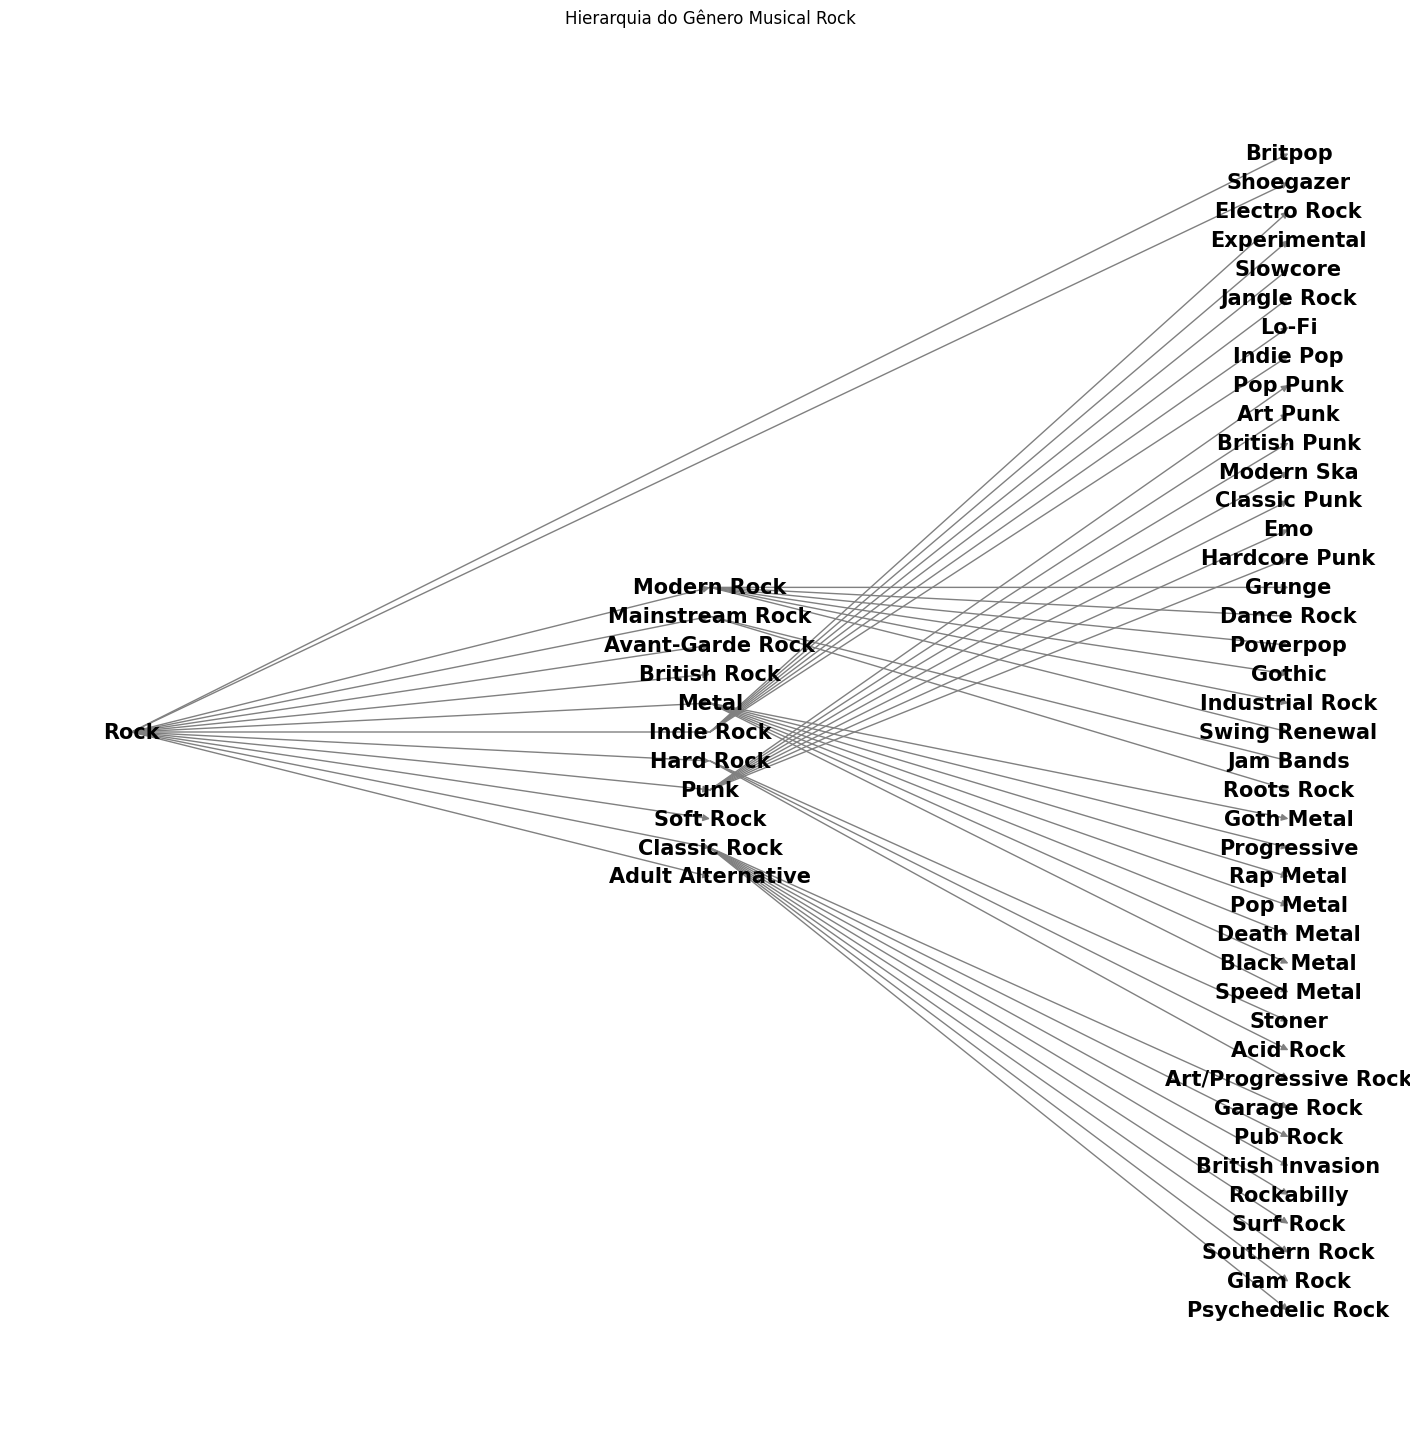

In [ ]:
# Exemplo: Geração de subgrafo para o gênero 'Rock'
root_genre_name = 'Rock'
subgraph = create_subgraph(G, root_genre_name)

draw_subgraph(subgraph)

## Sunburst plot

In [ ]:
columns = ["id", "parent_id", "level", "genre_name"]
hierarchy_df = pd.read_csv(genre_hierarchy_path, sep="\t", names=columns)

# Criar o mapa de id para nome e id para parent_id
id_to_name = dict(zip(hierarchy_df['id'], hierarchy_df['genre_name']))
parent_map = dict(zip(hierarchy_df['id'], hierarchy_df['parent_id']))

# Função para construir o caminho hierárquico
def build_hierarchy_path(genre_id, id_to_name, parent_map, max_depth):
    path = []
    current_id = genre_id
    while current_id != None and len(path) < max_depth:
        path.append(id_to_name.get(current_id, ""))
        current_id = parent_map.get(current_id, 0)
    path.reverse()
    return path + [""] * (max_depth - len(path))

max_depth = 4

# Construir os caminhos hierárquicos para todos os gêneros
paths = [build_hierarchy_path(row['id'], id_to_name, parent_map, max_depth) for _, row in hierarchy_df.iterrows()]

path_df = pd.DataFrame(paths, columns=[f"Step {i+1}" for i in range(max_depth)])
path_df  # exibir uma amostra do resultado

,Step 1,Step 2,Step 3,Step 4
0,Music,Music,Music,Unknown
1,Music,Music,Music,Electronic/Dance
2,Music,Music,Electronic/Dance,Ambient
3,Music,Electronic/Dance,Ambient,Ambient Dub
4,Music,Electronic/Dance,Ambient,Ambient Tech
...,...,...,...,...
212,Music,Music,Easy Listening,Vocal Standards
213,Music,Music,Easy Listening,Lounge
214,Music,Music,Easy Listening,Orchestral
215,Music,Music,Easy Listening,Classical


In [ ]:
# Remover repetições consecutivas do caminho
def simplify_path(path):
    return [genre for i, genre in enumerate(path) if i == 0 or genre != path[i - 1]]

# Simplificar cada caminho
simplified_paths = [simplify_path(path) for path in paths]

# Criar o DataFrame ajustado
simplified_df = pd.DataFrame(simplified_paths, columns=[f"Step {i+1}" for i in range(max_depth)])

simplified_df = simplified_df.where(pd.notnull(simplified_df), None)

simplified_df  # exibir uma amostra do resultado ajustado

,Step 1,Step 2,Step 3,Step 4
0,Music,Unknown,None,None
1,Music,Electronic/Dance,None,None
2,Music,Electronic/Dance,Ambient,None
3,Music,Electronic/Dance,Ambient,Ambient Dub
4,Music,Electronic/Dance,Ambient,Ambient Tech
...,...,...,...,...
212,Music,Easy Listening,Vocal Standards,None
213,Music,Easy Listening,Lounge,None
214,Music,Easy Listening,Orchestral,None
215,Music,Easy Listening,Classical,None


In [ ]:
# Exportar dataframe para poda manual no Excel
simplified_df.to_csv('/content/sample_data/genre_hierarchy_hierarchical_paths.csv', index=False)

In [ ]:
# Recarregar o dataframe
genre_hierarchy_sunburst_url = 'https://drive.google.com/uc?export=download&id=1U0shHKMMXi0vqXDhWUJgJMMDOGv6IfSh'
genre_hierarchy_sunburst_path = '/content/sample_data/genre_hierarchy_sunburst_df.csv'
download_file(genre_hierarchy_sunburst_url, genre_hierarchy_sunburst_path)

df = pd.read_csv('/content/sample_data/genre_hierarchy_sunburst_df.csv')

print(df.head())

File downloaded with success!
  Step 1            Step 2              Step 3        Step 4
0  Music           Unknown                 NaN           NaN
1  Music  Electronic/Dance             Ambient   Ambient Dub
2  Music  Electronic/Dance             Ambient  Ambient Tech
3  Music  Electronic/Dance              Breaks           NaN
4  Music  Electronic/Dance  Jungle / Drum &amp          Bass


In [ ]:
# Remover linhas vazias
df.dropna(how='all', inplace=True)

# Resetar o index
df.reset_index(drop=True, inplace=True)

# Trocar valores NaN por None
df = df.where(pd.notnull(df), None)

df

,Step 1,Step 2,Step 3,Step 4
0,Music,Unknown,None,None
1,Music,Electronic/Dance,Ambient,Ambient Dub
2,Music,Electronic/Dance,Ambient,Ambient Tech
3,Music,Electronic/Dance,Breaks,None
4,Music,Electronic/Dance,Jungle / Drum &amp,Bass
...,...,...,...,...
175,Music,Comedy,Sketch,None
176,Music,Easy Listening,Vocal Standards,None
177,Music,Easy Listening,Lounge,None
178,Music,Easy Listening,Orchestral,None


In [ ]:
fig = px.sunburst(
    df,
    path=[f"Step {i+1}" for i in range(max_depth)],  # Hierarchical path columns
    #title="Genre Hierarchy Sunburst Chart",
    width=900,
    height=900,
)

fig.show()